# G5HT-PIPELINE

first transfers data from flvc to local directory, then moves results back to flvc

The transferring code assumes you have set up an ssh key

__set up ssh key__

https://github.com/flavell-lab/FlavellLabWiki/wiki/Setting-up-SSH-key-on-Windows
- generate ssh key
- add to github account
- transfer authorized keys to flvc
  - type in powershell:
    - Get-Content "$env:USERPROFILE\.ssh\id_rsa.pub" | ssh munib@flv-c2.mit.edu "mkdir -p ~/.ssh && cat >> ~/.ssh/authorized_keys"
- done, should be able to ssh into flvc (ssh flvc or ssh munib@flv-c3) without entering password

## CONDA ENVIRONMENTS

For steps __transfer files__, __1. preprocess__ and __2. mip__, `conda activate g5ht-pipeline`

For step __3. segment__, `conda activate segment-torch` or `conda activate torchcu129`

For step __4. spline, 5. orient, 6. warp, 7. reg__, `conda activate g5ht-pipeline`


__NOTE__

You will need ~200GB of storage space locally for a single recording. After registration, you can delete ~150GB
- .nd2: 50GB  (~55GB if separate channel alignment recording taken)
- .h5: 9GB
- .tifs created from shear_correction, channel_alignment, bleach_correction: 47GB each     (shear_correction, channel_alignment can be deleted after running the full pipeline)
- .tifs created from warping and registering: 18GB each      (warped can be deleted after running the full pipeline)

__NOTE:__

For transferring from flvc to windows pc, just use scp:

```
scp munib@flv-c2.mit.edu:/store1/shared/g5ht/data/20260220/date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm007.h5 C:\Users\munib\POSTDOC\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm007.h5

scp munib@flv-c2.mit.edu:/store1/shared/g5ht/data/20260220/date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm007.nd2 C:\Users\munib\POSTDOC\DATA\g5ht-free\20260220\date-20260220_strain-ISg5HT-NSM-TeTx_condition-starvedpatch_worm007.nd2


rsync -avzP -e ssh -o --exclude=channel_aligned/ --exclude=shear_corrected/ /c/Users/munib/POSTDOC/DATA/g5ht-free/20260217/date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003/ munib@flv-c2:/store1/shared/g5ht/data/20260217/date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003


```

For transferring results back to flvc from windows pc, use rsync in msys. see __COPY RESULTS TO FLVC__ section

## IMPORTS

In [1]:
import sys
import os
import importlib
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
import shutil

try:
    import utils
    is_torch_env = False
except ImportError:
    is_torch_env = True
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

## SPECIFY DATA TO PROCESS

In [2]:
flvc = 'munib@flv-c3' # this is the username and hostname of the linux machine (c2,c3,c4)
data_dir_flvc = r'/store1/shared/g5ht/data' # this is a linux machine
data_dir_local = Path(r'C:\Users\munib\POSTDOC\DATA\g5ht-free') # this is a windows machine

# dataset (see datasets.txt)
dataset = 'date-20251223_strain-ISg5HT_condition-starvedpatch_worm004.nd2' 

INPUT_ND2 = dataset
date_str = INPUT_ND2.split('_')[0].split('-')[1]
local_dir = data_dir_local / date_str
local_dir.mkdir(parents=True, exist_ok=True)
INPUT_ND2_PTH = os.path.join(local_dir, INPUT_ND2)

NOISE_PTH = r'C:\Users\munib\POSTDOC\CODE\g5ht-pipeline\noise\noise_111125.tif'

OUT_DIR = os.path.splitext(INPUT_ND2_PTH)[0]

STACK_LENGTH = 41 if 'immo' not in INPUT_ND2 else 122

# for recordings prior to roughly December 2025, we want to keep all but the last two z-slices, during which the piezo position is unstable
# after December 2025, we want to keep all but the first two z-slices, during which the piezo position is unstable at the beginning of the recording
date_obj = datetime.strptime(date_str, '%Y%m%d')
if date_obj < datetime(2025, 12, 1):
    z2keep =  (0,STACK_LENGTH-2) # tuple representing range of z-slices to keep, should keep all but the last two slices
else:
    z2keep =  (2,STACK_LENGTH) # tuple representing range of z-slices to keep, should keep all but the first two slices


# if data already exists locally, then we can skip the copying step and just load the data. if not, then we need to copy the data from the linux machine to the local machine
data_exists_locally = False
if os.path.exists(INPUT_ND2_PTH):
    data_exists_locally = True
    print(f"Data file {INPUT_ND2_PTH} already exists locally. Will load data from local path.")
    print('')
    print("Jump to step 1. shear correction")
    print('')
    if not is_torch_env:
        noise_stack = utils.get_noise_stack(NOISE_PTH, STACK_LENGTH)
        num_frames, height, width, num_channels = utils.get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 
        beads_alignment_file = utils.get_beads_alignment_file(INPUT_ND2_PTH)
    else:
        print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

    print(INPUT_ND2)
    print('Num z-slices: ', STACK_LENGTH)
    if not is_torch_env:
        print('Number of frames: ', num_frames)
        print('Height: ', height)
        print('width: ', width)
        print('Number of channels: ', num_channels)
        print('Beads alignment file: ', beads_alignment_file)
else:
    print(f"Data file {INPUT_ND2_PTH} does not exist locally. Will copy from {flvc}.")

Data file C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004.nd2 already exists locally. Will load data from local path.

Jump to step 1. shear correction

date-20251223_strain-ISg5HT_condition-starvedpatch_worm004.nd2
Num z-slices:  41
Number of frames:  1200
Height:  512
width:  512
Number of channels:  2
Beads alignment file:  None


## TRANSFER FILES

Takes about 20 mins

In [ ]:
# transfer the files
if not data_exists_locally:
    utils.scp_from_flvc(dataset, data_dir_flvc, data_dir_local, flvc) # ~10 mins from flvc to local windows
    utils.scp_from_flvc(os.path.splitext(dataset)[0] + '.h5', data_dir_flvc, data_dir_local, flvc) # ~ 3 mins
    utils.scp_from_flvc(os.path.splitext(dataset)[0] + '_chan_alignment.nd2', data_dir_flvc, data_dir_local, flvc) # ~ 3 mins

## 0. GET META DATA

In [ ]:
if not is_torch_env:
    noise_stack = utils.get_noise_stack(NOISE_PTH, STACK_LENGTH)
    num_frames, height, width, num_channels = utils.get_range_from_nd2(INPUT_ND2_PTH, stack_length=STACK_LENGTH) 
    beads_alignment_file = utils.get_beads_alignment_file(INPUT_ND2_PTH)
else:
    print("utils not loaded because conda environment doesn't have nd2reader installed. probably using torchcu129 env, which is totally fine for just doing the segmentation step")

print(INPUT_ND2)
print('Num z-slices: ', STACK_LENGTH)
if not is_torch_env:
    print('Number of frames: ', num_frames)
    print('Height: ', height)
    print('width: ', width)
    print('Number of channels: ', num_channels)
    print('Beads alignment file: ', beads_alignment_file)

## 1. SHEAR CORRECTION 

` conda activate g5ht-pipeline`

~ 1 hour for 1200 image stacks with 2 color channels, 41 z, 512 h, 512 w

- shear corrects each volume
  - depending on each exposure time, it can take roughly half a second between the first and last frames of a volume, so any movements need to be corrected for
- creates one `.tif` for each volume and stores it in the `shear_corrected` directory

In [58]:
import shear_correct
_ = importlib.reload(sys.modules['shear_correct'])

start_index = "0"
end_index = str(num_frames-1)
# start_index = "59"
# end_index = "803"
# cpu_count = str(int(os.cpu_count() / 4))
cpu_count = str(int(os.cpu_count()))
skip_shear_correction = False # if True, will just denoise and save as tif

# sys.argv = ["", nd2 file, start_frame, end_frame, noise_pth, stack_length, n_workers, num_frames, height, width, num_channels]
sys.argv = ["", INPUT_ND2_PTH, start_index, end_index, NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, z2keep, skip_shear_correction]

# Call the main function
shear_correct.main()

Processing 1200 stacks (0-1199) using 20 workers...


100%|██████████| 1200/1200 [48:33<00:00,  2.43s/it] 


Parallel preprocessing complete.


## 2. CHANNEL ALIGNMENT

` conda activate g5ht-pipeline`

Takes around 30 minutes for 1200 image stacks with 2 color channels, 39 z, 512 h, 512 w

### 2a. GET MEDIAN CHANNEL ALIGNMENT PARAMETERS FROM ALL FRAMES

- If channel alignment file found, uses that, if not uses worm recording
- creates a `.txt` file for each volume that contains elastix channel registration parameters
- creates `chan_align_params.csv` and  `chan_align.txt`

In [ ]:
beads_alignment_file

In [3]:
import get_channel_alignment
import median_channel_alignment
_ = importlib.reload(sys.modules['get_channel_alignment'])
_ = importlib.reload(sys.modules['median_channel_alignment'])

## set beads_alignment_file to None to use worm recording for channel alignment, even if beads file exists
# beads_alignment_file = None

start_index = "0"
end_index = str(num_frames-1)

cpu_count = str(int(os.cpu_count() / 4))
# cpu_count = str(int(os.cpu_count()))

every_other = False # if True, will only use every other frame for channel alignment, which should be sufficient and will speed up the process by 2x

if beads_alignment_file is not None:
    align_with_beads = True
    every_other = False # if using beads for alignment, we want to use all frames because there's only 50
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", beads_alignment_file, start_index, end_index, NOISE_PTH, STACK_LENGTH, cpu_count, num_frames_beads, height, width, num_channels, every_other, align_with_beads]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, end_index, NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, every_other, align_with_beads]

# # Call the main function
get_channel_alignment.main()
median_channel_alignment.main()


### 2b. APPLY MEDIAN CHANNEL ALIGNMENT PARAMETERS

- ouputs aligned volumes in `channel_aligned` directory

In [4]:
import apply_channel_alignment
_ = importlib.reload(sys.modules['apply_channel_alignment'])

start_index = "0"
end_index = str(num_frames-1)
cpu_count = str(int(os.cpu_count() / 4))
# cpu_count = str(int(os.cpu_count()))

# 0786 to 0799 are bad frames in worm005.nd2, copied 0785 for each of those frames

if beads_alignment_file is not None:
    align_with_beads = True
    num_frames_beads, _, _, _ = utils.get_range_from_nd2(beads_alignment_file, stack_length=STACK_LENGTH) 
    sys.argv = ["", INPUT_ND2_PTH, start_index, end_index, NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads, beads_alignment_file]
else:
    align_with_beads = False
    sys.argv = ["", INPUT_ND2_PTH, start_index, end_index, NOISE_PTH, STACK_LENGTH, cpu_count, num_frames, height, width, num_channels, align_with_beads]


# Call the main function
apply_channel_alignment.main()

Processing 1200 stacks (0-1199) using 5 workers...


100%|██████████| 1200/1200 [04:45<00:00,  4.20it/s]


Parallel preprocessing complete.


### 2c. PLOT CHANNEL ALIGNMENT PARAMETER DISTRIBUTIONS

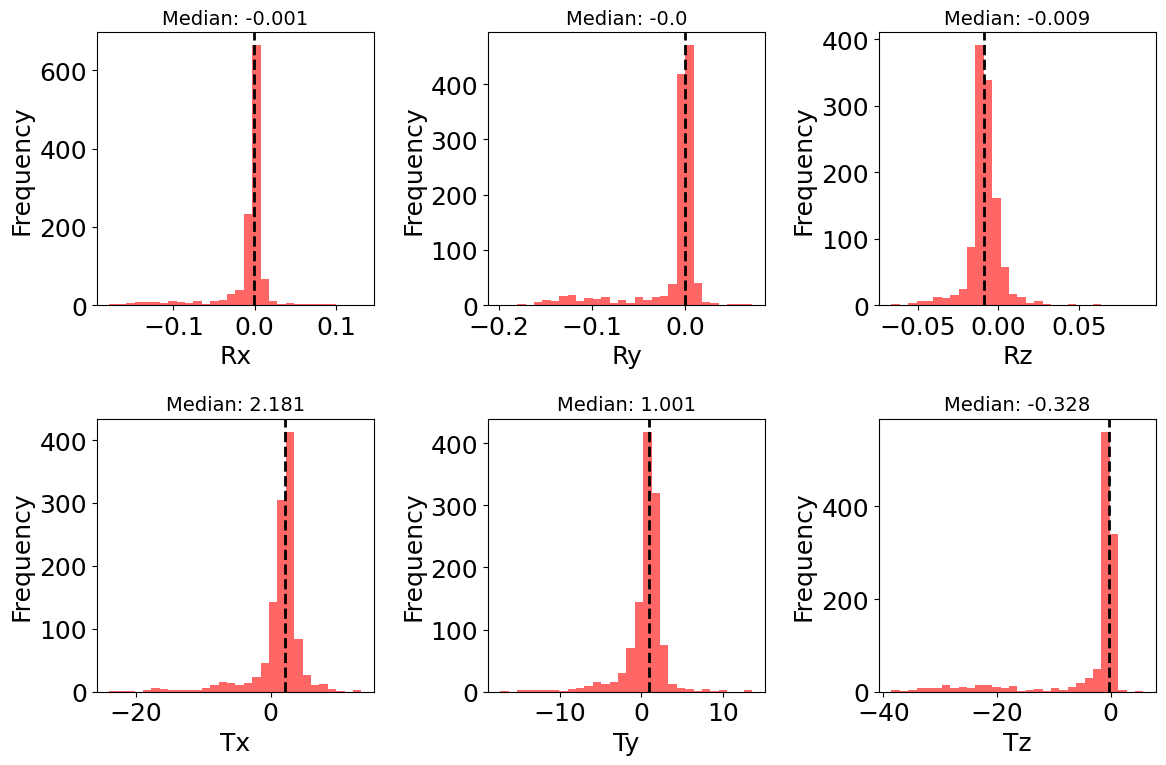

No chan_align_params.csv found for beads recording


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# make font sizes larger for visibility
plt.rcParams.update({'font.size': 18})

try:
    out_dir = os.path.splitext(INPUT_ND2_PTH)[0]

    df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
    params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
    labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

    # the xaxis limits for each subplot should be the same across figures

    xlims = np.zeros((6,2))

    plt.figure(figsize=(12,8), tight_layout=True)
    for i,param in enumerate(params):
        plt.subplot(2, 3, i+1)
        plt.hist(df[param], bins=30, color='red', alpha=0.6)
        # plot the median value as a vertical line
        median_value = df[param].median()
        plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
        plt.xlabel(labels[i])
        plt.ylabel('Frequency')
        # get xaxis limits
        xlims[i,:] = plt.xlim()
        # title is median value
        plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
    plt.savefig(os.path.join(out_dir, 'chan_align_params_histograms.png'))
    plt.show()
except FileNotFoundError:
    print("No chan_align_params.csv found for worm recording")

try:
    out_dir = os.path.splitext(INPUT_ND2_PTH)[0] + '_chan_alignment'
    df = pd.read_csv(os.path.join(out_dir, 'chan_align_params.csv'))
    params = ['TransformParameter_0', 'TransformParameter_1', 'TransformParameter_2', 'TransformParameter_3', 'TransformParameter_4', 'TransformParameter_5']
    labels = ['Rx', 'Ry', 'Rz', 'Tx', 'Ty', 'Tz']

    plt.figure(figsize=(12,8), tight_layout=True)
    for i,param in enumerate(params):
        plt.subplot(2, 3, i+1)
        plt.hist(df[param], bins=30, color='blue', alpha=0.6)
        # plot the median value as a vertical line
        median_value = df[param].median()
        plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
        plt.xlabel(labels[i])
        plt.ylabel('Frequency')
        # apply xlims
        # plt.xlim(xlims[i,0], xlims[i,1])
        # title is median value, font size 14
        plt.title(f'Median: {np.round(median_value,3)}', fontsize=14)
    plt.savefig(os.path.join(out_dir, 'chan_align_params_histograms.png'))
    plt.show()
except FileNotFoundError:
    print("No chan_align_params.csv found for beads recording")

## 3. BLEACH CORRECTION

Takes about 5 minutes

In [6]:
import importlib
import os
import sys

import bleach_correct
_ = importlib.reload(sys.modules['bleach_correct'])


PTH = os.path.splitext(INPUT_ND2_PTH)[0]
REG_DIR = 'channel_aligned' # 'channel_aligned' or 'tif' 
channels = 1 # 0-gfp, 1-rfp
method = 'block' # 'block' or 'exponential'
mode = 'total' # 'total' or 'median'
output_dir = os.path.join(PTH, 'bleach_corrected')

bleach_correct.correct_bleaching(os.path.join(PTH,REG_DIR), output_dir=output_dir, channels=channels, method=method, fbc=0.04, intensity_mode=mode)


# # Correct RFP only with block method (default)
# correct_bleaching("path/to/data")

# # Correct both channels with exponential fit
# correct_bleaching("path/to/data", channels=[0, 1], method='exponential')

# # Command line
# python bleach_correct.py path/to/data --channels 0 1 --method exponential

Found 1200 volumes in C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004\channel_aligned
Channels to correct: ['RFP']
Method: block
Intensity mode: total

Processing RFP channel (index 1)
  Calculating total RFP signal...
Calculating RFP total signal: volume 1200/1200
  Divided into 25 blocks
  Computing block mean signals...
    Block 1/25: volumes 0-49, mean signal = 3.14e+08
    Block 2/25: volumes 50-60, mean signal = 3.09e+08
    Block 3/25: volumes 61-82, mean signal = 3.05e+08
    Block 4/25: volumes 83-97, mean signal = 3.00e+08
    Block 5/25: volumes 98-106, mean signal = 2.96e+08
    Block 6/25: volumes 107-113, mean signal = 2.92e+08
    Block 7/25: volumes 114-119, mean signal = 2.88e+08
    Block 8/25: volumes 120-121, mean signal = 2.84e+08
    Block 9/25: volumes 122-125, mean signal = 2.79e+08
    Block 10/25: volumes 126-132, mean signal = 2.75e+08
    Block 11/25: volumes 133-151, mean signal = 2.71e+08
    Block

## 4. MIP

` conda activate g5ht-pipeline`

- outputs `means.png`, `focus.png`, `mip.tif`, and `mip.mp4`, `focus_check.csv`

##### TODO: 
- mip for xy, xz, zy
- mip for several slices

In [7]:
import mip

_ = importlib.reload(sys.modules['mip'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
framerate = 8
tif_dir = 'bleach_corrected' # one of 'shear_corrected' 'channel_aligned' 'bleach_corrected'
# tif_dir = 'shear_corrected'
rmax = 850
gmax = 150
mp4_quality = 10
do_focus = True
sys.argv = ["", INPUT_ND2_PTH, tif_dir, STACK_LENGTH, num_frames, framerate, rmax, gmax, mp4_quality, do_focus]

# Call the main function
mip.main()

Checking focus... 

100%|██████████| 1200/1200 [00:52<00:00, 22.67it/s]
<tifffile.TiffWriter 'mip_bleach_corrected.tif'> writing nonconformant BigTIFF ImageJ


0000.tif written to mip_bleach_corrected.tif
0001.tif written to mip_bleach_corrected.tif
0002.tif written to mip_bleach_corrected.tif
0003.tif written to mip_bleach_corrected.tif
0004.tif written to mip_bleach_corrected.tif
0005.tif written to mip_bleach_corrected.tif
0006.tif written to mip_bleach_corrected.tif
0007.tif written to mip_bleach_corrected.tif
0008.tif written to mip_bleach_corrected.tif
0009.tif written to mip_bleach_corrected.tif
0010.tif written to mip_bleach_corrected.tif
0011.tif written to mip_bleach_corrected.tif
0012.tif written to mip_bleach_corrected.tif
0013.tif written to mip_bleach_corrected.tif
0014.tif written to mip_bleach_corrected.tif
0015.tif written to mip_bleach_corrected.tif
0016.tif written to mip_bleach_corrected.tif
0017.tif written to mip_bleach_corrected.tif
0018.tif written to mip_bleach_corrected.tif
0019.tif written to mip_bleach_corrected.tif
0020.tif written to mip_bleach_corrected.tif
0021.tif written to mip_bleach_corrected.tif
0022.tif w

## 5 DRIFT ESTIMATION

` conda activate g5ht-pipeline`

- outputs  `z_selection.csv`, `z_selection_diagnostics.png`, `sharpness.csv`

Few minutes to run

TODO:
- use z selection going forward
- also use sharpness/focus (and other things) to determine good/bad frames

In [8]:
import drift_estimation

_ = importlib.reload(sys.modules['drift_estimation'])
_ = importlib.reload(sys.modules['utils'])

# command-line arguments
tif_dir = 'bleach_corrected' # one of 'shear_corrected' 'channel_aligned' 'bleach_corrected'

sys.argv = ["", INPUT_ND2_PTH, tif_dir, STACK_LENGTH, num_frames]

# Call the main function
drift_estimation.main()

Computing sharpness-based focus metrics...


Computing sharpness: 100%|██████████| 1200/1200 [03:52<00:00,  5.16it/s]



Z-slice selection complete:
  Total frames: 1200
  Z-slices per frame: 24
  Frames needing padding: 862 (71.8%)
  Total drift: 6.15 z-slices
  Max drift from start: 14.32 z-slices


## 6. SEGMENT

- outputs `label.tif`, contains segmented MIP for each volume

__on home pc__: 
`conda activate segment-torch`

Uses a separate conda environment from the rest of the pipeline. create it using:
`conda env create -f segment_torch.yml`

__on lab pc__: 
`conda activate torchcu129`

Uses a separate conda environment from the rest of the pipeline. create it following steps in:
`segment_torch_cu129_environment.yml`

__setup each time model weights change__
Need to set path to model weights as `CHECKPOINT` in `eval_torch.py`

a minute to run

In [3]:
import segment.segment_torch
_ = importlib.reload(sys.modules['segment.segment_torch'])

mip_tif = 'mip_bleach_corrected'
# mip_tif = 'mip_channel_aligned' 

MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], f'{mip_tif}.tif')

# command-line arguments
sys.argv = ["", MIP_PTH]

segment.segment_torch.main()

mip_bleach_corrected: 0
mip_bleach_corrected: 4
mip_bleach_corrected: 8
mip_bleach_corrected: 12
mip_bleach_corrected: 16
mip_bleach_corrected: 20
mip_bleach_corrected: 24
mip_bleach_corrected: 28
mip_bleach_corrected: 32
mip_bleach_corrected: 36
mip_bleach_corrected: 40
mip_bleach_corrected: 44
mip_bleach_corrected: 48
mip_bleach_corrected: 52
mip_bleach_corrected: 56
mip_bleach_corrected: 60
mip_bleach_corrected: 64
mip_bleach_corrected: 68
mip_bleach_corrected: 72
mip_bleach_corrected: 76
mip_bleach_corrected: 80
mip_bleach_corrected: 84
mip_bleach_corrected: 88
mip_bleach_corrected: 92
mip_bleach_corrected: 96
mip_bleach_corrected: 100
mip_bleach_corrected: 104
mip_bleach_corrected: 108
mip_bleach_corrected: 112
mip_bleach_corrected: 116
mip_bleach_corrected: 120
mip_bleach_corrected: 124
mip_bleach_corrected: 128
mip_bleach_corrected: 132
mip_bleach_corrected: 136
mip_bleach_corrected: 140
mip_bleach_corrected: 144
mip_bleach_corrected: 148
mip_bleach_corrected: 152
mip_bleach_cor

## 7. SPLINE

`conda activate g5ht-pipeline`

- outputs `spline.json`, `spline.tif`, and `dilated.tif`

In [4]:
import spline
_ = importlib.reload(sys.modules['spline'])

LABEL_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'label.tif')

# command-line arguments
sys.argv = ["", LABEL_PTH]

spline.main()

100%|██████████| 1200/1200 [00:57<00:00, 20.80it/s]


## 8. ORIENT

`conda activate g5ht-pipeline`

- outputs `oriented.json`, `oriented.png`, `oriented_stack.tif`

NOTE: `orient_v2.py` automated the process of finding orientation completely, whereas `orient.py` requires you to input the (x,y) nose location on the first frame

For `orient.py`, you have to specify the nose (x,y) coordinates for the first frame (and maybe others if needed). Look at `spline.tif` for this

100%|██████████| 1200/1200 [00:02<00:00, 543.81it/s]


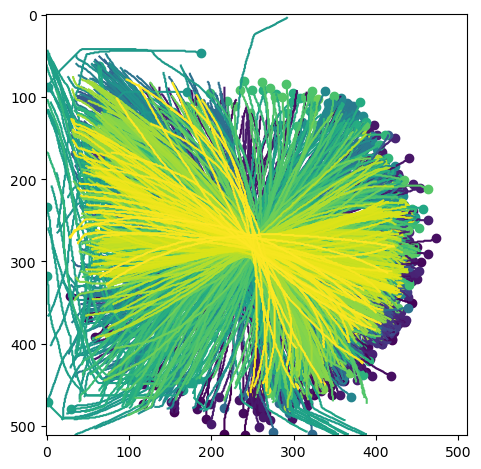

Rendering and collecting frames...


100%|██████████| 1200/1200 [01:07<00:00, 17.83it/s]


Saving TIFF stack to: C:\Users\munib\POSTDOC\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004\oriented_stack.tif
TIFF stack saved successfully.


<Figure size 640x480 with 0 Axes>

In [3]:
import orient
_ = importlib.reload(sys.modules['orient'])

SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')
nose_y = 398
nose_x = 62


# command-line arguments
# sys.argv = ["", SPLINE_PTH, str(nose_y), str(nose_x)]

# # apply constraints
# # might need this when there are frames where the spline fitting fails and orientation is lost intermittently
# # each constraint is a triplet: (frame, nose_y, nose_x)
constraints = [
    (652, 485, 260),
    (710, 227, 432),
    (862, 81, 284),
]

# # with constraints: append triplets of (frame, nose_y, nose_x)
constraint_args = []
for frame, cy, cx in constraints:
    constraint_args.extend([str(frame), str(cy), str(cx)])
sys.argv = ["", SPLINE_PTH, str(nose_y), str(nose_x)] + constraint_args


orient.main()

In [ ]:
# import orient_v2 # tried to automate finding nose point, not working well at the moment
# _ = importlib.reload(sys.modules['orient_v2'])

# SPLINE_PTH = MIP_PTH = os.path.join(os.path.splitext(INPUT_ND2_PTH)[0], 'spline.json')

# # command-line arguments
# sys.argv = ["", SPLINE_PTH]

# orient_v2.main()

## 9. WARP

`conda activate g5ht-pipeline`

- ouputs: `warped/*.tif` and `masks/*.tif`

TODO: parallelize

takes 1-2 hours

In [4]:
import warp
_ = importlib.reload(sys.modules['warp'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 0
end_index = num_frames

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    sys.argv = ["", PTH, i]

    warp.main()

100%|██████████| 1200/1200 [1:29:31<00:00,  4.48s/it]


## 10. REGISTER

`conda activate g5ht-pipeline`

__ALTERNATIVELY__: register using the wholistic registration algorithm, currently in MATLAB

TODO: parallelize / make faster

- pick a good representative fixed frame that you want to register everything to
  - copy it to the main output folder and name it `fixed_xxxx.tif`
  - copy the corresponding mask and name it `fixed_mask_xxxx.tif`

Takes around 5 hours for 1200 stacks

### MAKE COPIES OF FIXED FRAME AND MASK

In [5]:
fixed_frame = '0450'

PTH = os.path.splitext(INPUT_ND2_PTH)[0]
warped_dir = os.path.join(PTH, 'warped')
mask_dir = os.path.join(PTH, 'masks')

warped_fixed_frame_pth = os.path.join(warped_dir, f'{fixed_frame}.tif')
mask_fixed_frame_pth = os.path.join(mask_dir, f'{fixed_frame}.tif')

shutil.copy(warped_fixed_frame_pth, os.path.join(PTH, f'fixed_{fixed_frame}.tif'))
shutil.copy(mask_fixed_frame_pth, os.path.join(PTH, f'fixed_mask_{fixed_frame}.tif'))

'C:\\Users\\munib\\POSTDOC\\DATA\\g5ht-free\\20251223\\date-20251223_strain-ISg5HT_condition-starvedpatch_worm004\\fixed_mask_0450.tif'

### REGISTER

In [ ]:
import reg
_ = importlib.reload(sys.modules['reg'])

PTH = os.path.splitext(INPUT_ND2_PTH)[0]

start_index = 280
end_index = num_frames
zoom = 1 # albert was using 3
# zoom = 3

for i in tqdm(range(start_index, end_index)):
    # command-line arguments
    try:
        sys.argv = ["", PTH, i, str(zoom)]
        reg.main()
    except Exception as e:
        print(f"Error processing index {i}: {e}")   

 24%|██▎       | 281/1191 [1:20:32<4:23:38, 17.38s/it]

### REGISTER WITH GFP+1 TO RFP

TRIM LAST RFP ZSLICE, TRIM FIRST GFP ZSLICE

seems to be that as of 20251204, all recordings were taken such that the i zslice in red channel corresponds to i+1 zslice in green channel

In [ ]:
import sys
import os
from tqdm import tqdm
import importlib

from reg_gfp_indexing import main as reg_worm

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

for i in tqdm(range(1200)):
    # command-line arguments
    sys.argv = ["", PTH, i, "1"]
    reg_worm()

### MAKE MOVIES OF REGISTERED DATA (also see `reg_microfilm.ipynb`)

In [ ]:
import tifffile
import numpy as np
import os
import imageio
import cv2

def make_rgb(frame, rmax, gmax, shape=(200, 500, 3)):
    """Creates an RGB image from a frame."""
    gfp, rfp = frame
    rgb = np.zeros(shape, np.ubyte)
    adjust = lambda frame, lo, hi: np.clip((frame.astype(np.float32) - lo) / (hi - lo), 0, 1)
    rgb[..., 0] = adjust(rfp, 0, rmax) * 255
    rgb[..., 1] = adjust(gfp, 0, gmax) * 255
    return rgb


def write_mp4(mp4_path, tif_dir, rmax, gmax, fps, quality):
    """Creates an MP4 file from MIP TIF files with frame number overlay."""
    # Note: 'libx264' is usually higher quality than 'mjpeg' if your imageio has it
    with imageio.get_writer(mp4_path, fps=fps, codec='libx264', quality=quality) as mp4:
        tifs = sorted([f for f in os.listdir(tif_dir) if f.endswith('.tif')])
        
        for i, tif in enumerate(tifs):
            print(f"Processing: {tif}")
            
            # Load and project
            frame_data = tifffile.imread(os.path.join(tif_dir, tif))
            # Shape is (C, Z, H, W) or (Z, C, H, W) based on your logic:
            # Assuming np.max(frame, axis=0) leaves you with (C, H, W)
            mip_frame = np.max(frame_data, axis=0) 

            # Create the RGB image
            rgb_frame = make_rgb(mip_frame, rmax, gmax)
            
            # --- TEXT OVERLAY SECTION ---
            # Extract frame number from filename or use index 'i'
            text = f"Frame: {os.path.splitext(tif)[0]}"
            time_sec = i / fps
            text += f"  Time: {time_sec:.2f} sec"
            
            # cv2.putText(image, text, org(x,y), font, scale, color, thickness)
            # Using white text (255, 255, 255) with a slight black outline for visibility
            font = cv2.FONT_HERSHEY_SIMPLEX
            org = (20, 20) # 20px from left, 20px from top
            font_scale = 0.6
            thickness = 2
            
            # Optional: Black outline for better readability on bright backgrounds
            cv2.putText(rgb_frame, text, org, font, font_scale, (0, 0, 0), thickness + 2)
            # Main white text
            cv2.putText(rgb_frame, text, org, font, font_scale, (255, 255, 255), thickness)
            # ----------------------------

            mp4.append_data(rgb_frame)

PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003'
fps = (1/0.533)
quality = 10
mp4_pth = os.path.join(PTH, 'registered_elastix.mp4')
rmax = 1000
gmax = 200
write_mp4(mp4_pth, os.path.join(PTH, 'registered_elastix'), rmax, gmax, fps, quality)


## 10. EXTRACT BEHAVIOR

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import hdf5plugin
import h5py


PTH = os.path.splitext(INPUT_ND2_PTH)[0]
FN = PTH + '.h5'

f = h5py.File(FN, 'r')

im = f.get('img_nir')[:] # THW
sz = im.shape

fps = 20.0  # frames per second

print('Video shape: ', sz)

nframes = im.shape[0]
record_duration = nframes / fps # in seconds

print('Recording duration (s): ', record_duration)

### MAKE NIR MP4

In [ ]:
# save im, which is of shape (frame, height, width) as a .mp4 video
import cv2
out_fn = os.path.join(PTH, 'nir_video.mp4')
if not os.path.exists(PTH):
    os.makedirs(PTH)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(out_fn, fourcc, fps, (sz[2], sz[1]), isColor=False)
# save video
for i in range(nframes):
    # print status every 100 frames
    if i % 100 == 0:
        print('Saving frame: ', i, ' / ', nframes)
    frame = im[i,:,:]
    frame = (frame / np.max(frame) * 255).astype(np.uint8)
    # overlay frame with text of frame number and time in seconds
    time_sec = i / fps
    text = f'Frame: {i}  Time: {time_sec:.2f} s'
    cv2.putText(frame, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255), 2)
    # frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    out.write(frame)
out.release()
print('Saved video to: ', out_fn)


## COPY RESULTS TO FLVC

Files that should be copied back to flvc:
- from wormXXX directory
  - transfer everything except:
    - channel_aligned/*
    - shear_corrected/*
    - warped/*
- the wormXXX_chan_alignment directory and contents if it exists


Takes about an hour

In msys:

A dry run:

rsync -avzP -e ssh -o --dry-run --exclude=channel_aligned/ --exclude=shear_corrected/ /c/Users/munib/POSTDOC/DATA/g5ht-free/20251028/date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002/ munib@flv-c2:/home/munib/store1/shared/g5ht/data/20251028/date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002

real thing:
rsync -avzP -e ssh -o --dry-run --exclude=channel_aligned/ --exclude=shear_corrected/ /c/Users/munib/POSTDOC/DATA/g5ht-free/20251028/date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002/ munib@flv-c2:/home/munib/store1/shared/g5ht/data/20251028/date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm002


In [ ]:

# this just prints the rsync command for you to run in terminal (msys on windows)
import subprocess
from pathlib import Path, PurePosixPath
import os

# --- CONFIGURATION ---
DRY_RUN = True  # Set to False to actually transfer files

msys_path = r"C:\msys64\usr\bin"
os.environ["PATH"] = msys_path + os.pathsep + os.environ["PATH"]
RSYNC_EXE = r"C:\msys64\usr\bin\rsync.exe"

flvc = 'munib@flv-c2'
data_dir_remote_base = PurePosixPath('/store1/shared/g5ht/data')
data_dir_local_base = Path(r'C:\Users\munib\POSTDOC\DATA\g5ht-free')

dataset_base = os.path.splitext(INPUT_ND2)[0]  # reuse from earlier cell
date_str = dataset_base.split('_')[0].split('-')[1]

EXCLUSIONS = ["channel_aligned/", "shear_corrected/"] # transfer everything in results output but these

def to_msys_path(win_path):
    """Convert a Windows path to an MSYS2/Cygwin-style path for rsync."""
    p = Path(win_path).resolve()
    drive = p.drive.replace(":", "").lower()
    rest = "/".join(p.parts[1:])
    return f"/{drive}/{rest}"

def rsync_push(local_path, remote_path, exclusions=None):
    """Push a local directory to a remote host via rsync.
    
    Trailing slash on local_path means 'copy contents into remote_path'.
    """
    local_msys = to_msys_path(local_path).rstrip("/") + "/"
    remote_dest = f"{flvc}:{remote_path}"

    # cmd = [
    #     RSYNC_EXE,
    #     "-avzP",
    #     "-e", "ssh -o",
    # ]
    cmd = [
        "rsync",
        "-avzP",
        "-e", "ssh -o",
    ]
    if DRY_RUN:
        cmd.append("--dry-run")
    for pattern in (exclusions or []):
        cmd.append(f"--exclude={pattern}")
    cmd.extend([local_msys, remote_dest])

    print(f"{'[DRY RUN] ' if DRY_RUN else ''}Pushing: {local_path}  -->  {remote_dest}")

    print("Run in msys or linux terminal (remove --dry-run if you want to actually transfer files):\n:")
    print(" ".join(cmd), "\n")

    # result = subprocess.run(cmd, capture_output=True, text=True)
    # print(result.stdout)
    # if result.returncode != 0:
    #     print(f"*** rsync failed (exit {result.returncode}) ***")
    #     print(result.stderr)
    # return result.returncode

# --- SYNC MAIN DATASET DIRECTORY (excluding large intermediate dirs) ---
local_dir = data_dir_local_base / date_str / dataset_base
remote_dir = f"{data_dir_remote_base}/{date_str}/{dataset_base}"

if local_dir.exists():
    rsync_push(local_dir, remote_dir, exclusions=EXCLUSIONS)
else:
    print(f"Local directory not found, skipping: {local_dir}")

# --- SYNC CHANNEL ALIGNMENT DIRECTORY (if it exists) ---
align_dir = data_dir_local_base / date_str / (dataset_base + "_chan_alignment")
remote_align_dir = f"{data_dir_remote_base}/{date_str}/{dataset_base}_chan_alignment"

if align_dir.exists():
    rsync_push(align_dir, remote_align_dir)
else:
    print(f"No channel alignment directory found locally, skipping: {align_dir}")

## LOCAL FILES CAN NOW BE DELETED IF TRANSFER COMPLETED SUCCESSFULLY